In [9]:
%matplotlib inline

import numpy  as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as srn

from data_fetch import prepare_usps_mlfetch

In [10]:
[Xtrue,Xlabels] = prepare_usps_mlfetch()

data  = Xtrue
label = Xlabels

data_train    = data[0:220]
data_test     = data[220:231]
targets_train = label[0:220]
targets_test  = label[220:231]

# import tempfile
# from sklearn.datasets.mldata import fetch_mldata
# test_data_home = tempfile.mkdtemp()
# usps = fetch_mldata('usps', data_home = test_data_home)

importing usps from pickle file .....


## OC-SVM explicit

Explicit objective and gradient for the OC-SVM, minimised with scipy.

In [46]:
def relu(x):
    y = x
    y[y < 0] = 0
    return y

def dRelu(x):
    y = x
    y[x <= 0] = 0
    y[x > 0]  = np.ones((len(x[x > 0]),))
    return y

In [47]:
def svmScore(X, w):
    return X.dot(w)

def ocsvm_obj(theta, X, nu, D):
    
    w = theta[:D]
    r = theta[D:]
    
    term1 = 0.5 * np.sum(w**2)
    term2 = 1/nu * np.mean(relu(r - svmScore(X, w)))
    term3 = -r
    
    return term1 + term2 + term3

def ocsvm_grad(theta, X, nu, D):
    
    w = theta[:D]
    r = theta[D:]
    
    deriv = dRelu(r - svmScore(X, w))

    term1 = np.append(w, 0)
    term2 = np.append(1/nu * np.mean(deriv[:,np.newaxis] * (-X), axis = 0),
                      1/nu * np.mean(deriv))
    term3 = np.append(0*w, -1)

    grad = term1 + term2 + term3
    
    return grad

In [48]:
from scipy.optimize import minimize

X  = data_train
D  = X.shape[1]
nu = 0.04

np.random.seed(42)
theta0 = np.random.normal(0, 1, D + 1)

from scipy.optimize import check_grad
print('Gradient error: %s' % check_grad(ocsvm_obj, ocsvm_grad, theta0, X, nu, D))

res = minimize(ocsvm_obj, theta0, method = 'L-BFGS-B', jac = ocsvm_grad, args = (X, nu, D),
               options = {'gtol': 1e-8, 'disp': True, 'maxiter' : 50000, 'maxfun' : 10000})

Gradient error: 5.65966004199e-06


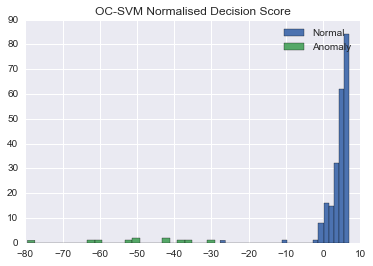

In [49]:
plt.hist(svmScore(data[label == +1, :], res.x[0:-1]) - res.x[-1], bins = 25, label = 'Normal');
plt.hist(svmScore(data[label == -1, :], res.x[0:-1]) - res.x[-1], bins = 25, label = 'Anomaly');
plt.legend(loc = 'upper right');
plt.title('OC-SVM Normalised Decision Score');

## OC-SVM sklearn

Comparison to sklearn implementation of OC-SVM.

In [50]:
from sklearn import svm

nu = 0.04
ocSVM = svm.OneClassSVM(nu = nu, kernel = 'linear')
ocSVM.fit(data_train) 

decisionScore = ocSVM.decision_function(data)

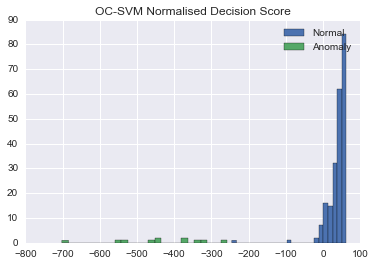

In [51]:
plt.hist(decisionScore[label == +1], bins = 25, label = 'Normal');
plt.hist(decisionScore[label == -1], bins = 25, label = 'Anomaly');
plt.legend(loc = 'upper right');
plt.title('OC-SVM Normalised Decision Score');

## OC-NN explicit

Define the OC-NN objective function as per the notes. It accepts the activation g(.) as an argument as well.

In [52]:
def nnScore(X, w, V, g):
    return g(X.dot(V)).dot(w)

def ocnn_obj(theta, X, nu, D, K, g, dG):
    
    w = theta[:K]
    V = theta[K:K+K*D].reshape((D, K))
    r = theta[K+K*D:]
    
    term1 = 0.5  * np.sum(w**2)
    term2 = 0.5  * np.sum(V**2)
    term3 = 1/nu * np.mean(relu(r - nnScore(X, w, V, g)))
    term4 = -r
    
    return term1 + term2 + term3 + term4

def ocnn_grad(theta, X, nu, D, K, g, dG):
    
    N = X.shape[0]
    w = theta[:K]
    V = theta[K:K+K*D].reshape((D, K))
    r = theta[K+K*D:]
    
    deriv = dRelu(r - nnScore(X, w, V, g))    

    term1 = np.concatenate(( w,
                             np.zeros((V.size,)),
                             np.zeros((1,)) ))

    term2 = np.concatenate(( np.zeros((w.size,)),
                             V.flatten(),
                             np.zeros((1,)) ))

    term3 = np.concatenate(( 1/nu * np.mean(deriv[:,np.newaxis] * (-g(X.dot(V))), axis = 0),
                             1/nu * np.mean((deriv[:,np.newaxis] * (dG(X.dot(V)) * -w)).reshape((N, 1, K)) * X.reshape((N, D, 1)), axis = 0).flatten(),
                             1/nu * np.array([ np.mean(deriv) ]) ))
    
    term4 = np.concatenate(( np.zeros((w.size,)),
                             np.zeros((V.size,)),
                             -1 * np.ones((1,)) ))
    
    return term1 + term2 + term3 + term4

### Linear activation

Minimise objective explicitly for some small number of hidden units.

In [53]:
from scipy.optimize import minimize

X  = data_train
D  = X.shape[1]
K  = 4
nu = 0.04

g  = lambda x : x
dG = lambda x : np.ones(x.shape)

np.random.seed(42)
theta0 = np.random.normal(0, 1, K + K*D + 1)

from scipy.optimize import check_grad
print('Gradient error: %s' % check_grad(ocnn_obj, ocnn_grad, theta0, X, nu, D, K, g, dG))

res = minimize(ocnn_obj, theta0, method = 'L-BFGS-B', jac = ocnn_grad, args = (X, nu, D, K, g, dG),
               options = {'gtol': 1e-8, 'disp': True, 'maxiter' : 50000, 'maxfun' : 10000})

Gradient error: 0.00032003848362


In [54]:
thetaStar = res.x

wStar = thetaStar[:K]
VStar = thetaStar[K:K+K*D].reshape((D, K))
rStar = thetaStar[K+K*D:]

In [55]:
# print('rStar vs percentile:')
# print((rStar[0], np.percentile(nnScore(data_train, wStar, VStar, g), q = 100 * nu)))

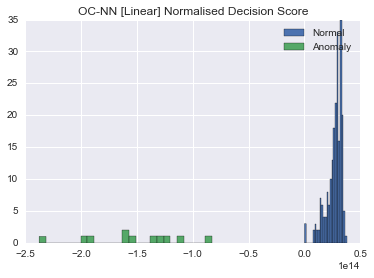

In [56]:
plt.hist(nnScore(data[label == +1], wStar, VStar, g) - rStar, bins = 25, label = 'Normal');
plt.hist(nnScore(data[label == -1], wStar, VStar, g) - rStar, bins = 25, label = 'Anomaly');
plt.legend(loc = 'upper right');
plt.title('OC-NN [Linear] Normalised Decision Score');

### Sigmoid activation

In [57]:
from scipy.optimize import minimize

X  = data_train
D  = X.shape[1]
K  = 4
nu = 0.04

g   = lambda x : 1/(1 + np.exp(-x))
dG  = lambda x : 1/(1 + np.exp(-x)) * 1/(1 + np.exp(+x))

np.random.seed(42)
theta0 = np.random.normal(0, 1, K + K*D + 1)

from scipy.optimize import check_grad
print('Gradient error: %s' % check_grad(ocnn_obj, ocnn_grad, theta0, X, nu, D, K, g, dG))

res = minimize(ocnn_obj, theta0, method = 'L-BFGS-B', jac = ocnn_grad, args = (X, nu, D, K, g, dG),
               options = {'gtol': 1e-8, 'disp': True, 'maxiter' : 50000, 'maxfun' : 10000})

Gradient error: 8.33498126439e-05


In [58]:
# thetaStar = res.x

# wStar = thetaStar[:K]
# VStar = thetaStar[K:K+K*D].reshape((D, K))
# rStar = thetaStar[K+K*D:]

In [59]:
thetaStar = theta0

wStar = thetaStar[:K]
VStar = thetaStar[K:K+K*D].reshape((D, K))
rStar = thetaStar[K+K*D:]

In [62]:
print wStar
print VStar

[ 0.49671415 -0.1382643   0.64768854  1.52302986]
[[-0.23415337 -0.23413696  1.57921282  0.76743473]
 [-0.46947439  0.54256004 -0.46341769 -0.46572975]
 [ 0.24196227 -1.91328024 -1.72491783 -0.56228753]
 ..., 
 [-0.651418   -0.48388583 -0.32034731  0.42416595]
 [ 0.52283549 -0.5737     -0.02435459  2.14227036]
 [ 1.72754317  0.43632367  0.03800348  0.12003133]]


In [60]:
# print('rStar vs percentile:')
# print((rStar[0], np.percentile(nnScore(data_train, wStar, VStar, g), q = 100 * nu)))

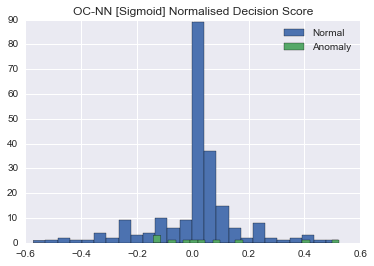

In [61]:
plt.hist(nnScore(data[label == +1], wStar, VStar, g) - rStar, bins = 25, label = 'Normal');
plt.hist(nnScore(data[label == -1], wStar, VStar, g) - rStar, bins = 25, label = 'Anomaly');
plt.legend(loc = 'upper right');
plt.title('OC-NN [Sigmoid] Normalised Decision Score');

### Tflearn based Code for OC-NN 

Training Step: 599  | total loss: 0.00174 | time: 0.007s
| SGD | epoch: 200 | loss: 0.00174 - binary_acc: 1.0000 -- iter: 200/220
Training Step: 600  | total loss: 0.00174 | time: 0.011s
| SGD | epoch: 200 | loss: 0.00174 - binary_acc: 1.0000 -- iter: 220/220
--
Hideen [[ -4.98954214e-05  -8.29289183e-06   7.45984507e-05  -4.29097927e-05]
 [ -6.73346076e-05   4.92666259e-05  -7.67769961e-05  -1.34297370e-04]
 [ -1.46113698e-05  -1.32730900e-04  -1.70264364e-04  -1.41452882e-04]
 ..., 
 [ -8.07425531e-05  -2.68223666e-05  -6.60758014e-05  -6.81170422e-05]
 [  6.25834582e-06  -3.34725264e-05  -4.41674347e-05   5.91446769e-05]
 [  9.55018913e-05   4.13881899e-05  -3.95919451e-05  -9.08271250e-05]]
[[ 1.31013346]
 [ 1.30986619]
 [ 1.31075859]
 [ 1.30934143]]


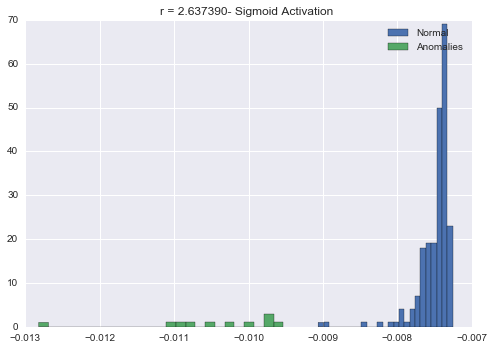

In [2]:
from tflearn import DNN
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression, oneClassNN
import tensorflow as tf
import tflearn
import numpy as np
import tflearn.variables as va
import numpy  as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as srn

from data_fetch import prepare_usps_mlfetch

[Xtrue,Xlabels] = prepare_usps_mlfetch()

data  = Xtrue
label = Xlabels
data_train    = data[0:220]
data_test     = data[220:231]
targets_train = label[0:220]
targets_test  = label[220:231]
# Clear all the graph variables created in previous run and start fresh
# tf.reset_default_graph()

## Set up the data for running the algorithm
data_train = data[0:220]
target = Xlabels
X = data_train
Y = targets_train
Y = Y.tolist()
Y = [[i] for i in Y]

# For testing the algorithm
X_test = data_test
Y_test = targets_test
Y_test = Y_test.tolist()
Y_test = [[i] for i in Y_test]

No_of_inputNodes = X.shape[1]
K = 4
nu = 0.04
D = X.shape[1]

# Define the network
input_layer = input_data(shape=[None, No_of_inputNodes])  # input layer of size

np.random.seed(42)
theta0 = np.random.normal(0, 1, K + K*D + 1) *0.0001
#theta0 = np.random.normal(0, 1, K + K*D + 1) # For linear
hidden_layer = fully_connected(input_layer, 4, bias=False, activation='sigmoid', name="hiddenLayer_Weights",
                               weights_init="normal")  # hidden layer of size 2


output_layer = fully_connected(hidden_layer, 1, bias=False, activation='linear', name="outputLayer_Weights",
                               weights_init="normal")  # output layer of size 1



# Hyper parameters for the one class Neural Network
v = 0.04
nu = 0.04

# Initialize rho
value = 0.01
init = tf.constant_initializer(value)
rho = va.variable(name='rho', dtype=tf.float32, shape=[], initializer=init)

rcomputed = []
auc = []


sess = tf.Session()
sess.run(tf.initialize_all_variables())
print sess.run(tflearn.get_training_mode()) #False
tflearn.is_training(True, session=sess)
print sess.run(tflearn.get_training_mode())  #now True

X  = data_train
D  = X.shape[1]
nu = 0.04




# temp = np.random.normal(0, 1, K + K*D + 1)[-1]

temp = theta0[-1]

# temp = tflearn.variables.get_value(rho, session=sess)

oneClassNN = oneClassNN(output_layer, v, rho, hidden_layer, output_layer, optimizer='sgd',
                        loss='OneClassNN_Loss',
                            learning_rate=1)

model = DNN(oneClassNN, tensorboard_verbose=3)

model.set_weights(output_layer.W, theta0[0:K][:,np.newaxis])
model.set_weights(hidden_layer.W, np.reshape(theta0[K:K +K*D],(D,K)))


iterStep = 0
while (iterStep < 100):
    print "Running Iteration :", iterStep
    # Call the cost function
    y_pred = model.predict(data_train)  # Apply some ops
    tflearn.is_training(False, session=sess)
    y_pred_test = model.predict(data_test)  # Apply some ops
    tflearn.is_training(True, session=sess)
    value = np.percentile(y_pred, v * 100)
    tflearn.variables.set_value(rho, value,session=sess)
    rStar = rho
    model.fit(X, Y, n_epoch=2, show_metric=True, batch_size=100)
    iterStep = iterStep + 1
    rcomputed.append(rho)
    temp = tflearn.variables.get_value(rho, session=sess)

    # print "Rho",temp
    # print "y_pred",y_pred
    # print "y_predTest", y_pred_test

# g = lambda x: x
g   = lambda x : 1/(1 + tf.exp(-x))

def nnScore(X, w, V, g):
    return tf.matmul(g((tf.matmul(X, w))), V)





# Format the datatype to suite the computation of nnscore
X = X.astype(np.float32)
X_test = data_test
X_test = X_test.astype(np.float32)
# assign the learnt weights
# wStar = hidden_layer.W
# VStar = output_layer.W
# Get weights values of fc2
wStar = model.get_weights(hidden_layer.W)
VStar = model.get_weights(output_layer.W)

print "Hideen",wStar
print VStar

train = nnScore(X, wStar, VStar, g)
test = nnScore(X_test, wStar, VStar, g)

# Access the value inside the train and test for plotting
# Create a new session and run the example
# sess = tf.Session()
# sess.run(tf.initialize_all_variables())
arrayTrain = train.eval(session=sess)
arrayTest = test.eval(session=sess)

# print "Train Array:",arrayTrain
# print "Test Array:",arrayTest

plt.hist(arrayTrain-temp,  bins = 25,label='Normal');
plt.hist(arrayTest-temp, bins = 25, label='Anomalies');
plt.legend(loc='upper right')
plt.title('r = %1.6f- Sigmoid Activation ' % temp)
plt.show()


# TensorFlow : Implementation

### USPS :  One Class NN Anomaly Detect


importing usps from pickle file .....
Epoch = 1, r = 0.250003
Epoch = 2, r = 0.801360
Epoch = 3, r = 1.723956
Epoch = 4, r = 2.686446
Epoch = 5, r = 3.652274
Epoch = 6, r = 4.612071
Epoch = 7, r = 5.563688
Epoch = 8, r = 6.506463
Epoch = 9, r = 7.440176
Epoch = 10, r = 8.364771
Epoch = 11, r = 9.280262
Epoch = 12, r = 10.186694
Epoch = 13, r = 11.084131
Epoch = 14, r = 11.972646
Epoch = 15, r = 12.852317
Epoch = 16, r = 13.723223
Epoch = 17, r = 14.585447
Epoch = 18, r = 15.439071
Epoch = 19, r = 16.284177
Epoch = 20, r = 17.120849
Epoch = 21, r = 17.949168
Epoch = 22, r = 18.769217
Epoch = 23, r = 19.581076
Epoch = 24, r = 20.384828
Epoch = 25, r = 21.180552
Epoch = 26, r = 21.968327
Epoch = 27, r = 22.748232
Epoch = 28, r = 23.520346
Epoch = 29, r = 24.284745
Epoch = 30, r = 25.041506
Epoch = 31, r = 25.790706
Epoch = 32, r = 26.532419
Epoch = 33, r = 27.266721
Epoch = 34, r = 27.993685
Epoch = 35, r = 28.713384
Epoch = 36, r = 29.425891
Epoch = 37, r = 30.131277
Epoch = 38, r = 30.8

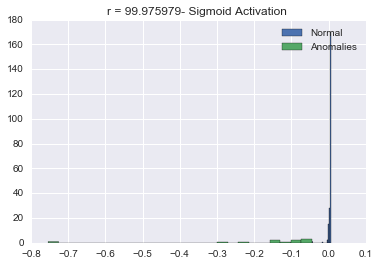

In [11]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as srn

from data_fetch import prepare_usps_mlfetch
tf.reset_default_graph()

RANDOM_SEED = 42
tf.set_random_seed(RANDOM_SEED)

[Xtrue,Xlabels] = prepare_usps_mlfetch()

data  = Xtrue
label = Xlabels

data_train    = data[0:220]
data_test     = data[220:231]
targets_train = label[0:220]
targets_test  = label[220:231]



data  = Xtrue
label = Xlabels

train_X    = data[0:220]
test_X     = data[220:231]
train_y = label[0:220]
test_y  = label[220:231]
train_y = train_y.tolist()
train_y = [[i] for i in train_y]

test_y = test_y.tolist()
test_y = [[i] for i in test_y]


 # Layer's sizes
x_size = train_X.shape[1]   # Number of input nodes: 4 features and 1 bias
h_size = 4                # Number of hidden nodes
y_size = 1   # Number of outcomes (3 iris flowers)
D = x_size
K = h_size

theta = np.random.normal(0, 1, K + K*D + 1) 
rvalue = np.random.normal(0,1,(len(train_X),y_size))
nu = 0.04



def init_weights(shape):
    """ Weight initialization """
    weights = tf.random_normal(shape,mean=0, stddev=0.00001)
    return tf.Variable(weights)

def forwardprop(X, w_1, w_2):
    """
    Forward-propagation.
    IMPORTANT: yhat is not softmax since TensorFlow's softmax_cross_entropy_with_logits() does that internally.
    """
    w_1 = tf.cast(w_1, tf.float64)
    w_2 = tf.cast(w_2, tf.float64)
    h    = tf.nn.sigmoid(tf.matmul(X, w_1))  # The \sigma function
    yhat = tf.matmul(h, w_2)  # The \varphi function
    return yhat

g   = lambda x : 1/(1 + tf.exp(-x))

def nnScore(X, w, V, g):
    w = tf.cast(w, tf.float64)
    V = tf.cast(V, tf.float64)
    return tf.matmul(g((tf.matmul(X, w))), V)

def relu(x):
    y = x
#     y[y < 0] = 0
    return y

def ocnn_obj(theta, X, nu, w1, w2, g,r):
    
    w = w1
    V = w2

   
    X = tf.cast(X, tf.float64)
    w = tf.cast(w1, tf.float64)
    V = tf.cast(w2, tf.float64)

    
    term1 = 0.5  * tf.reduce_sum(w**2)
    term2 = 0.5  * tf.reduce_sum(V**2)
    term3 = 1/nu * tf.reduce_mean(relu(r - nnScore(X, w, V, g)))
    term4 = -r
    
    return term1 + term2 + term3 + term4




# For testing the algorithm
X_test = data_test
Y_test = targets_test
Y_test = Y_test.tolist()
Y_test = [[i] for i in Y_test]

# Symbols
X = tf.placeholder("float64", shape=[None, x_size])

r = tf.get_variable("r", dtype=tf.float64,shape=(),trainable=False)

# Weight initializations
w_1 = init_weights((x_size, h_size))
w_2 = init_weights((h_size, y_size))

# Forward propagation
yhat    = forwardprop(X, w_1, w_2)
predict = tf.argmax(yhat, axis=1)


# Backward propagation
# cost    = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=yhat))
cost    = ocnn_obj(theta, X, nu, w_1, w_2, g,r)
updates = tf.train.GradientDescentOptimizer(0.01).minimize(cost)

# Run SGD
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
rvalue = 0.1
for epoch in range(1000):
        # Train with each example
            sess.run(updates, feed_dict={X: train_X,r:rvalue})
            rvalue = nnScore(train_X, w_1, w_2, g)
            with sess.as_default():
                rvalue = rvalue.eval()
                rvalue = np.percentile(rvalue,q=100*0.04)
            print("Epoch = %d, r = %f"
              % (epoch + 1,rvalue))

            
train = nnScore(train_X, w_1, w_2, g)
test = nnScore(test_X, w_1, w_2, g)
with sess.as_default():
    arrayTrain = train.eval()
    arrayTest = test.eval()
#     rstar = r.eval()

rstar =rvalue
sess.close()
print "Session Closed!!!"

plt.hist(arrayTrain-rstar,  bins = 25,label='Normal');
plt.hist(arrayTest-rstar, bins = 25, label='Anomalies');
plt.legend(loc='upper right')
plt.title('r = %1.6f- Sigmoid Activation ' % rstar)
plt.show()
  

### Prepare Datasets for validating the algorithm
    1) CIFAR-10 Datasets 220 images of dogs and 11 images of cats.\n
    2) SPAM - Data set 220 sentences of HAM and 11 sentences of SPAM \n
    3) Fake news dataset 220 documents of type X and 11 sentences of type XX \n
    4) Protein Sequence Data 220 sequences of Soluble and 11 sequences of insoluble \n
    5) KDD Cup data : Prepare the data set for anomaly detection.\n

### Fake News Data Preparation Step

Hate Class Shape (246, 2)
Fake Class shape (19, 2)
(265,)
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


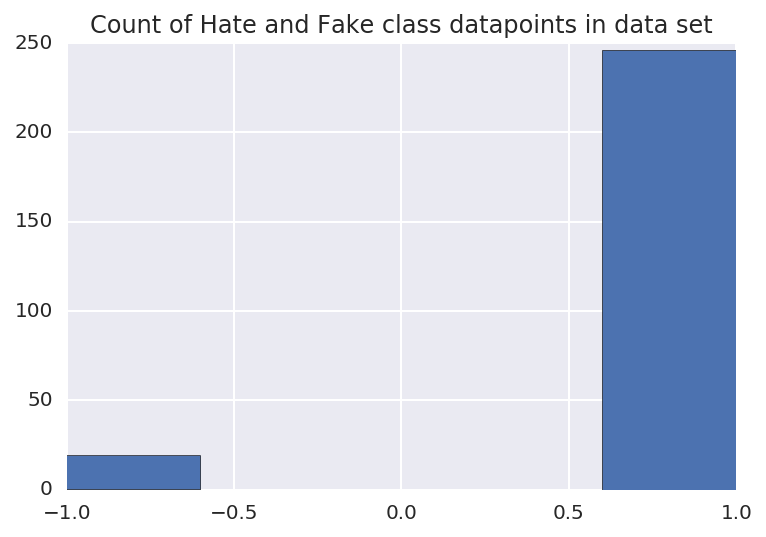

In [24]:
%matplotlib inline  
import pandas as pd
import numpy as np
import spacy
import scattertext as st
#import imp; imp.reload(st)
from IPython.display import IFrame
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
import pickle
from nltk.corpus import reuters

nlp = spacy.en.English()
uci_df = pd.read_csv('data/uci-news-aggregator.csv.gz')
traditional_publishers = ['Forbes','Bloomberg','Los Angeles Times','TIME','Wall Street Journal']
repubable_celebrity_gossip = ['TheCelebrityCafe.com', 'PerezHilton.com']
real_df = uci_df[uci_df['PUBLISHER'].isin(traditional_publishers)]
real_df.columns = [x.lower() for x in real_df.columns]
real_df['type'] = 'traditional'
df = pd.read_csv('data/fake.csv.gz')
df = df.append(real_df)
df = df[df['title'].apply(lambda x: type(x) == str)]
df['clean_title'] = df['title'].apply(lambda x: ' '.join(x.split('»')[0].split('>>')[0].split('[')[0].split('(')[0].split('|')[0].strip().split()))
df = df.ix[df['clean_title'].drop_duplicates().index]
# df['parsed_title'] = df['clean_title'].apply(nlp)
df['meta'] = df['author'].fillna('') + df['publisher'].fillna('') + ' ' + df['site_url'].fillna('')
df['category'] = df['type'].apply(lambda x: 'Real' if x == 'traditional' else 'Fake')
fake_df = df[df['category'] == 'Fake']

df_hate = fake_df[fake_df['type']=="hate"]
df_fake = fake_df[fake_df['type']=="fake"]

df_hate = df_hate[['text','type']]
df_fake = df_fake[['text','type']]

%config InlineBackend.figure_format = 'retina'
# let's take a look at the types of labels  are present in the data.
# The +1 correspond to label hate and -1(outliers) correspond to label fake
# print df_hate.head(5)
# print df_fake.head(5)

df_hate['type'][df_hate.type == "hate"] = 1
df_fake['type'][df_fake.type == "fake"] = -1


Xlabels_hate = df_hate['type'].values 
Xlabels_fake = df_fake['type'].values 

Xlabels = np.concatenate((Xlabels_hate,Xlabels_fake),axis=0)

print "Hate Class Shape",df_hate.shape
print "Fake Class shape",df_fake.shape
print Xlabels.shape
print Xlabels
import matplotlib.pyplot as plt
plt.hist(Xlabels,bins=5)
plt.title("Count of Hate and Fake class datapoints in data set")
plt.show()

In [33]:
### text vectorization--go from strings to lists of numbers
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectPercentile, f_classif

vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5)
data_train_transformed = vectorizer.fit_transform(df_hate['text']).toarray()
data_test_transformed  = vectorizer.transform(df_fake['text']).toarray()
# data_train_transformed = vectorizer.fit_transform(df_hate['text'])
# data_test_transformed  = vectorizer.transform(df_fake['text'])

# print "Hate News",(data_train_transformed[:10])
# print "Fake News",(data_test_transformed[:10])
print data_train_transformed.shape
print data_test_transformed.shape

print type(data_train_transformed)
print type(data_test_transformed)

# # slim the data for training and testing
# selector = SelectPercentile(f_classif, percentile=1)
# labels_train = Xlabels_hate
# labels_test = Xlabels_fake
# selector.fit(data_train_transformed, labels_train)
# data_train_transformed = selector.transform(data_train_transformed).toarray()
# data_test_transformed  = selector.transform(data_test_transformed).toarray()

# print data_train_transformed.shape
# print data_test_transformed.shape

# print type(data_train_transformed)
# print type(data_test_transformed)

data_train_transformed
data_test_transformed
labels_train = Xlabels_hate
labels_test = Xlabels_fake

data_train    = data_train_transformed
data_test     = data_test_transformed
targets_train = labels_train
targets_test  = labels_test

train_X    = data_train_transformed
test_X     = data_test_transformed
train_y = labels_train
test_y  = labels_test
train_y = train_y.tolist()
train_y = [[i] for i in train_y]

test_y = test_y.tolist()
test_y = [[i] for i in test_y]

(246, 17977)
(19, 17977)
<type 'numpy.ndarray'>
<type 'numpy.ndarray'>




## Fake News Detection:  One Class NN  Tensorflow Implementation

Epoch = 1, r = 180.651049
Epoch = 2, r = 357.361248
Epoch = 3, r = 532.377237
Epoch = 4, r = 705.728595
Epoch = 5, r = 877.502365
Epoch = 6, r = 1047.715673
Epoch = 7, r = 1216.476608
Epoch = 8, r = 1383.676800
Epoch = 9, r = 1549.528991
Epoch = 10, r = 1713.948131
Epoch = 11, r = 1877.189654
Epoch = 12, r = 2039.001872
Epoch = 13, r = 2199.400691
Epoch = 14, r = 2358.794343
Epoch = 15, r = 2516.862639
Epoch = 16, r = 2673.633724
Epoch = 17, r = 2829.542449
Epoch = 18, r = 2984.351604
Epoch = 19, r = 3137.984597
Epoch = 20, r = 3290.451752
Epoch = 21, r = 3441.846936
Epoch = 22, r = 3592.383734
Epoch = 23, r = 3742.057709
Epoch = 24, r = 3890.863515
Epoch = 25, r = 4038.858949
Epoch = 26, r = 4186.009541
Epoch = 27, r = 4332.284895
Epoch = 28, r = 4477.695184
Epoch = 29, r = 4622.325435
Epoch = 30, r = 4766.186665
Epoch = 31, r = 4909.303524
Epoch = 32, r = 5051.706814
Epoch = 33, r = 5193.417924
Epoch = 34, r = 5334.457594
Epoch = 35, r = 5474.845954
Epoch = 36, r = 5614.602520
Epoch 

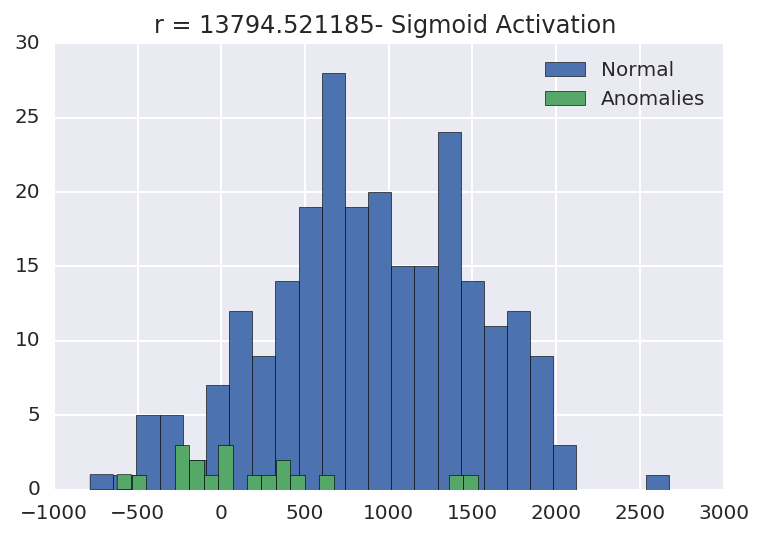

In [9]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as srn

from data_fetch import prepare_usps_mlfetch
tf.reset_default_graph()

RANDOM_SEED = 42
tf.set_random_seed(RANDOM_SEED)





 # Layer's sizes
x_size = train_X.shape[1]   # Number of input nodes: 4 features and 1 bias
h_size = 5000                # Number of hidden nodes
y_size = 1   # Number of outcomes (3 iris flowers)
D = x_size
K = h_size

theta = np.random.normal(0, 1, K + K*D + 1) 
rvalue = np.random.normal(0,1,(len(train_X),y_size))
nu = 0.07



def init_weights(shape):
    """ Weight initialization """
    weights = tf.random_normal(shape,mean=0, stddev=0.1)
    return tf.Variable(weights)

def forwardprop(X, w_1, w_2):
    """
    Forward-propagation.
    IMPORTANT: yhat is not softmax since TensorFlow's softmax_cross_entropy_with_logits() does that internally.
    """
    w_1 = tf.cast(w_1, tf.float64)
    w_2 = tf.cast(w_2, tf.float64)
    h    = tf.nn.sigmoid(tf.matmul(X, w_1))  # The \sigma function
    yhat = tf.matmul(h, w_2)  # The \varphi function
    return yhat

g   = lambda x : 1/(1 + tf.exp(-x))

def nnScore(X, w, V, g):
    w = tf.cast(w, tf.float64)
    V = tf.cast(V, tf.float64)
    return tf.matmul(g((tf.matmul(X, w))), V)

def relu(x):
    y = x
#     y[y < 0] = 0
    return y

def ocnn_obj(theta, X, nu, w1, w2, g,r):
    
    w = w1
    V = w2

   
    X = tf.cast(X, tf.float64)
    w = tf.cast(w1, tf.float64)
    V = tf.cast(w2, tf.float64)

    
    term1 = 0.5  * tf.reduce_sum(w**2)
    term2 = 0.5  * tf.reduce_sum(V**2)
    term3 = 1/nu * tf.reduce_mean(relu(r - nnScore(X, w, V, g)))
    term4 = -r
    
    return term1 + term2 + term3 + term4




# For testing the algorithm
X_test = data_test
Y_test = targets_test
Y_test = Y_test.tolist()
Y_test = [[i] for i in Y_test]

# Symbols
X = tf.placeholder("float64", shape=[None, x_size])

r = tf.get_variable("r", dtype=tf.float64,shape=(),trainable=False)

# Weight initializations
w_1 = init_weights((x_size, h_size))
w_2 = init_weights((h_size, y_size))

# Forward propagation
yhat    = forwardprop(X, w_1, w_2)
predict = tf.argmax(yhat, axis=1)


# Backward propagation
# cost    = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=yhat))
cost    = ocnn_obj(theta, X, nu, w_1, w_2, g,r)
updates = tf.train.GradientDescentOptimizer(0.01).minimize(cost)

# Run SGD
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
rvalue = 0.1
for epoch in range(100):
        # Train with each example
            sess.run(updates, feed_dict={X: train_X,r:rvalue})
            rvalue = nnScore(train_X, w_1, w_2, g)
            with sess.as_default():
                rvalue = rvalue.eval()
                rvalue = np.percentile(rvalue,q=100*0.07)
            print("Epoch = %d, r = %f"
              % (epoch + 1,rvalue))

            
train = nnScore(train_X, w_1, w_2, g)
test = nnScore(test_X, w_1, w_2, g)
with sess.as_default():
    arrayTrain = train.eval()
    arrayTest = test.eval()
#     rstar = r.eval()

rstar =rvalue
sess.close()
print "Session Closed!!!"

plt.hist(arrayTrain-rstar,  bins = 25,label='Normal');
plt.hist(arrayTest-rstar, bins = 25, label='Anomalies');
plt.legend(loc='upper right')
plt.title('r = %1.6f- Sigmoid Activation ' % rstar)
plt.show()
  

### CIFAR-10 Data Preparation

In [34]:
from tflearn.datasets import cifar10
ROOT = "/Users/raghav/Documents/Uni/KDD-2017/sample_autoencoder/autoencode_softthreshold/cifar-10_data/"
image_and_anamolies = {'image': 5,'anomalies1':3,'anomalies2':3,'imagecount': 220,'anomaliesCount':11}

def prepare_cifar_data_with_anamolies(original,original_labels,image_and_anamolies):

    imagelabel = image_and_anamolies['image']
    imagecnt = image_and_anamolies['imagecount']

    idx = np.where(original_labels ==imagelabel)

    idx = idx[0][:imagecnt]


    data = original[idx]
    data_labels = original_labels[idx]
    
    anamoliescnt = image_and_anamolies['anomaliesCount']
    anamolieslabel1 = image_and_anamolies['anomalies1']

    anmolies_idx1 = np.where(original_labels ==anamolieslabel1)
    anmolies_idx1 = anmolies_idx1[0][:(anamoliescnt)]
    
    ana_images1 = original[anmolies_idx1]
    ana_images1_labels = original_labels[anmolies_idx1]

    anamolieslabel2 = image_and_anamolies['anomalies2']
    anmolies_idx2 = np.where(original_labels ==anamolieslabel2)
    anmolies_idx2 = anmolies_idx2[0][:(anamoliescnt)]
    
    anomalies = original[anmolies_idx2]
    anomalies_labels = original_labels[anmolies_idx2]


    return [data,data_labels,anomalies,anomalies_labels]

# load cifar-10 data
(X, Y), (testX, testY) = cifar10.load_data(ROOT)
testX = np.asarray(testX)
testY = np.asarray(testY)


[train_X,train_Y,testX,testY]=prepare_cifar_data_with_anamolies(X,Y,image_and_anamolies)



# Make the Dog samples as positive and cat samples as negative
testY[testY ==5] = 1
testY[testY ==3] =-1
test_y = [[i] for i in test_y]

## Modify to suite the tensorflow code 
train_Y[train_Y ==5]= 1
train_Y[train_Y ==3]= -1
train_y = [[i] for i in train_y]

train_X = np.reshape(train_X, (len(train_X),3072))
testX = np.reshape(testX, (len(testX),3072))

print "Data Train Shape",train_X.shape
print "Data Test Shape",testX.shape

print "Label Train Shape",train_Y.shape
print "Label Test Shape",testY.shape

data_train    = train_X
data_test     = testX
targets_train = train_Y
targets_test  = testY

train_X    = train_X
test_X     = testX
train_y = train_Y
test_y  = testY
train_y = train_y.tolist()
train_y = [[i] for i in train_y]

test_y = test_y.tolist()
test_y = [[i] for i in test_y]

Data Train Shape (220, 3072)
Data Test Shape (11, 3072)
Label Train Shape (220,)
Label Test Shape (11,)


## CIFAR-10 : Detecting Cats among Dog Images Dataset : Tensorflow Implement

Epoch = 1, r = 0.498026
Epoch = 2, r = 1.907997
Epoch = 3, r = 3.812342
Epoch = 4, r = 5.741950
Epoch = 5, r = 7.674460
Epoch = 6, r = 9.595110
Epoch = 7, r = 11.499127
Epoch = 8, r = 13.385543
Epoch = 9, r = 15.253018
Epoch = 10, r = 17.101695
Session Closed!!!


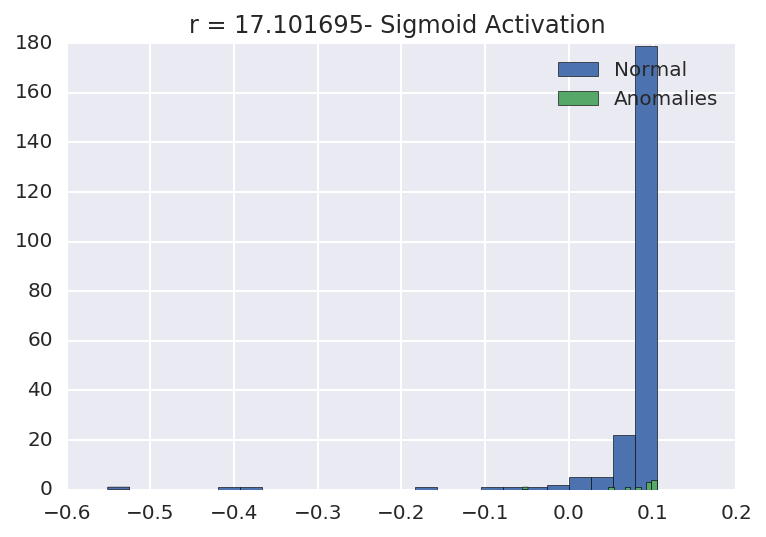

In [35]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as srn

from data_fetch import prepare_usps_mlfetch
tf.reset_default_graph()

RANDOM_SEED = 42
tf.set_random_seed(RANDOM_SEED)




 # Layer's sizes
x_size = train_X.shape[1]   # Number of input nodes: 4 features and 1 bias
h_size = 8               # Number of hidden nodes
y_size = 1   # Number of outcomes (3 iris flowers)
D = x_size
K = h_size

theta = np.random.normal(0, 1, K + K*D + 1) 
rvalue = np.random.normal(0,1,(len(train_X),y_size))
nu = 0.04



def init_weights(shape):
    """ Weight initialization """
    weights = tf.random_normal(shape,mean=0, stddev=0.001)
    return tf.Variable(weights)

def forwardprop(X, w_1, w_2):
    """
    Forward-propagation.
    IMPORTANT: yhat is not softmax since TensorFlow's softmax_cross_entropy_with_logits() does that internally.
    """
    w_1 = tf.cast(w_1, tf.float64)
    w_2 = tf.cast(w_2, tf.float64)
    h    = tf.nn.sigmoid(tf.matmul(X, w_1))  # The \sigma function
    yhat = tf.matmul(h, w_2)  # The \varphi function
    return yhat

g   = lambda x : 1/(1 + tf.exp(-x))

def nnScore(X, w, V, g):
    w = tf.cast(w, tf.float64)
    V = tf.cast(V, tf.float64)
    return tf.matmul(g((tf.matmul(X, w))), V)

def relu(x):
    y = x
#     y[y < 0] = 0
    return y

def ocnn_obj(theta, X, nu, w1, w2, g,r):
    
    w = w1
    V = w2

   
    X = tf.cast(X, tf.float64)
    w = tf.cast(w1, tf.float64)
    V = tf.cast(w2, tf.float64)

    
    term1 = 0.5  * tf.reduce_sum(w**2)
    term2 = 0.5  * tf.reduce_sum(V**2)
    term3 = 1/nu * tf.reduce_mean(relu(r - nnScore(X, w, V, g)))
    term4 = -r
    
    return term1 + term2 + term3 + term4




# For testing the algorithm
X_test = data_test
Y_test = targets_test
Y_test = Y_test.tolist()
Y_test = [[i] for i in Y_test]

# Symbols
X = tf.placeholder("float64", shape=[None, x_size])

r = tf.get_variable("r", dtype=tf.float64,shape=(),trainable=False)

# Weight initializations
w_1 = init_weights((x_size, h_size))
w_2 = init_weights((h_size, y_size))

# Forward propagation
yhat    = forwardprop(X, w_1, w_2)
predict = tf.argmax(yhat, axis=1)


# Backward propagation
# cost    = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=yhat))
cost    = ocnn_obj(theta, X, nu, w_1, w_2, g,r)
updates = tf.train.GradientDescentOptimizer(0.01).minimize(cost)

# Run SGD
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
rvalue = 0.1
for epoch in range(10):
        # Train with each example
            sess.run(updates, feed_dict={X: train_X,r:rvalue})
            rvalue = nnScore(train_X, w_1, w_2, g)
            with sess.as_default():
                rvalue = rvalue.eval()
                rvalue = np.percentile(rvalue,q=100*0.04)
            print("Epoch = %d, r = %f"
              % (epoch + 1,rvalue))

            
train = nnScore(train_X, w_1, w_2, g)
test = nnScore(test_X, w_1, w_2, g)
with sess.as_default():
    arrayTrain = train.eval()
    arrayTest = test.eval()
#     rstar = r.eval()

rstar =rvalue
sess.close()
print "Session Closed!!!"

plt.hist(arrayTrain-rstar,  bins = 25,label='Normal');
plt.hist(arrayTest-rstar, bins = 25, label='Anomalies');
plt.legend(loc='upper right')
plt.title('r = %1.6f- Sigmoid Activation ' % rstar)
plt.show()
  

### SPAM Vs HAM Detection Data Set Preparation

Ham Class Shape (220, 5)
Spam Class shape (11, 5)
(231,)
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


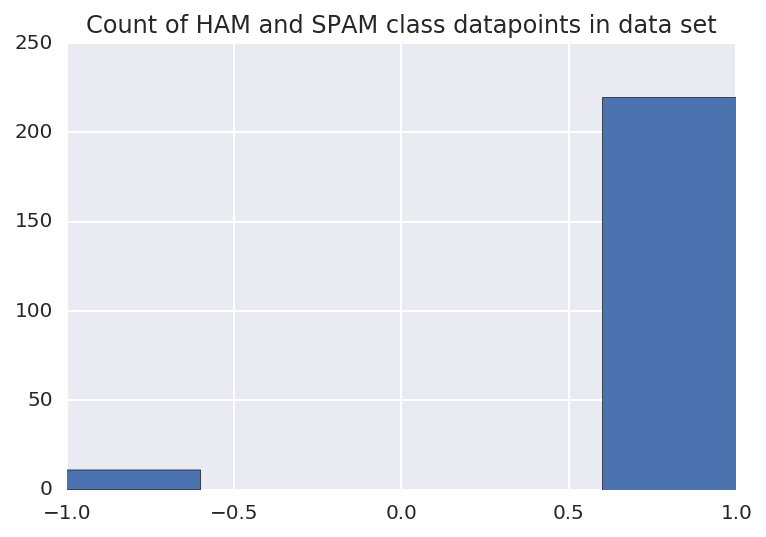

(220, 1048)
(11, 1048)
<type 'numpy.ndarray'>
<type 'numpy.ndarray'>


In [43]:
%config InlineBackend.figure_format = 'retina'
import pandas as pd
df = pd.read_csv('./data/spam.csv', encoding='latin-1')
df.head()
df.shape
# split into train and test

df_ham = df[df['v1']=="ham"]
df_spam = df[df['v1']=="spam"]



# let's take a look at the types of labels  are present in the data.
# The +1 correspond to label hate and -1(outliers) correspond to label fake
# print df_hate.head(5)
# print df_fake.head(5)

df_ham['v1'][df_ham.v1 == "ham"] = 1
df_spam['v1'][df_spam.v1 == "spam"] = -1

df_ham = df_ham[0:220]
df_spam = df_spam[0:11]

Xlabels_ham = df_ham['v1'].values 
Xlabels_spam = df_spam['v1'].values 

Xlabels = np.concatenate((Xlabels_ham,Xlabels_spam),axis=0)

print "Ham Class Shape",df_ham.shape
print "Spam Class shape",df_spam.shape
print Xlabels.shape
print Xlabels
import matplotlib.pyplot as plt
plt.hist(Xlabels,bins=5)
plt.title("Count of HAM and SPAM class datapoints in data set")
plt.show()


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectPercentile, f_classif

vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5)
data_train_transformed = vectorizer.fit_transform(df_ham['v2']).toarray()
data_test_transformed  = vectorizer.transform(df_spam['v2']).toarray()
# data_train_transformed = vectorizer.fit_transform(df_hate['text'])
# data_test_transformed  = vectorizer.transform(df_fake['text'])

# print "Hate News",(data_train_transformed[:10])
# print "Fake News",(data_test_transformed[:10])
print data_train_transformed.shape
print data_test_transformed.shape

print type(data_train_transformed)
print type(data_test_transformed)

# # slim the data for training and testing
# selector = SelectPercentile(f_classif, percentile=1)
# labels_train = Xlabels_hate
# labels_test = Xlabels_fake
# selector.fit(data_train_transformed, labels_train)
# data_train_transformed = selector.transform(data_train_transformed).toarray()
# data_test_transformed  = selector.transform(data_test_transformed).toarray()

# print data_train_transformed.shape
# print data_test_transformed.shape

# print type(data_train_transformed)
# print type(data_test_transformed)

data_train_transformed
data_test_transformed
labels_train = Xlabels_hate
labels_test = Xlabels_fake

data_train    = data_train_transformed
data_test     = data_test_transformed
targets_train = labels_train
targets_test  = labels_test

train_X    = data_train_transformed
test_X     = data_test_transformed
train_y = labels_train
test_y  = labels_test
train_y = train_y.tolist()
train_y = [[i] for i in train_y]

test_y = test_y.tolist()
test_y = [[i] for i in test_y]


## EMAIL SPAM Detection :  Tensorflow Implement

In [ ]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as srn

from data_fetch import prepare_usps_mlfetch
tf.reset_default_graph()

RANDOM_SEED = 42
tf.set_random_seed(RANDOM_SEED)




 # Layer's sizes
x_size = train_X.shape[1]   # Number of input nodes: 4 features and 1 bias
h_size = 8               # Number of hidden nodes
y_size = 1   # Number of outcomes (3 iris flowers)
D = x_size
K = h_size

theta = np.random.normal(0, 1, K + K*D + 1) 
rvalue = np.random.normal(0,1,(len(train_X),y_size))
nu = 0.04



def init_weights(shape):
    """ Weight initialization """
    weights = tf.random_normal(shape,mean=0, stddev=0.001)
    return tf.Variable(weights)

def forwardprop(X, w_1, w_2):
    """
    Forward-propagation.
    IMPORTANT: yhat is not softmax since TensorFlow's softmax_cross_entropy_with_logits() does that internally.
    """
    w_1 = tf.cast(w_1, tf.float64)
    w_2 = tf.cast(w_2, tf.float64)
    h    = tf.nn.sigmoid(tf.matmul(X, w_1))  # The \sigma function
    yhat = tf.matmul(h, w_2)  # The \varphi function
    return yhat

g   = lambda x : 1/(1 + tf.exp(-x))

def nnScore(X, w, V, g):
    w = tf.cast(w, tf.float64)
    V = tf.cast(V, tf.float64)
    return tf.matmul(g((tf.matmul(X, w))), V)

def relu(x):
    y = x
#     y[y < 0] = 0
    return y

def ocnn_obj(theta, X, nu, w1, w2, g,r):
    
    w = w1
    V = w2

   
    X = tf.cast(X, tf.float64)
    w = tf.cast(w1, tf.float64)
    V = tf.cast(w2, tf.float64)

    
    term1 = 0.5  * tf.reduce_sum(w**2)
    term2 = 0.5  * tf.reduce_sum(V**2)
    term3 = 1/nu * tf.reduce_mean(relu(r - nnScore(X, w, V, g)))
    term4 = -r
    
    return term1 + term2 + term3 + term4




# For testing the algorithm
X_test = data_test
Y_test = targets_test
Y_test = Y_test.tolist()
Y_test = [[i] for i in Y_test]

# Symbols
X = tf.placeholder("float64", shape=[None, x_size])

r = tf.get_variable("r", dtype=tf.float64,shape=(),trainable=False)

# Weight initializations
w_1 = init_weights((x_size, h_size))
w_2 = init_weights((h_size, y_size))

# Forward propagation
yhat    = forwardprop(X, w_1, w_2)
predict = tf.argmax(yhat, axis=1)


# Backward propagation
# cost    = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=yhat))
cost    = ocnn_obj(theta, X, nu, w_1, w_2, g,r)
updates = tf.train.GradientDescentOptimizer(0.01).minimize(cost)

# Run SGD
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
rvalue = 0.1
for epoch in range(10):
        # Train with each example
            sess.run(updates, feed_dict={X: train_X,r:rvalue})
            rvalue = nnScore(train_X, w_1, w_2, g)
            with sess.as_default():
                rvalue = rvalue.eval()
                rvalue = np.percentile(rvalue,q=100*0.04)
            print("Epoch = %d, r = %f"
              % (epoch + 1,rvalue))

            
train = nnScore(train_X, w_1, w_2, g)
test = nnScore(test_X, w_1, w_2, g)
with sess.as_default():
    arrayTrain = train.eval()
    arrayTest = test.eval()
#     rstar = r.eval()

rstar =rvalue
sess.close()
print "Session Closed!!!"

plt.hist(arrayTrain-rstar,  bins = 25,label='Normal');
plt.hist(arrayTest-rstar, bins = 25, label='Anomalies');
plt.legend(loc='upper right')
plt.title('r = %1.6f- Sigmoid Activation ' % rstar)
plt.show()

#### Run One Class NN on Fake News Data set Using TFlearn Implementation

In [ ]:
from tflearn import DNN
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression, oneClassNN
import tensorflow as tf
import tflearn
import numpy as np
import tflearn.variables as va
import numpy  as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as srn

# from data_fetch import prepare_usps_mlfetch

# [Xtrue,Xlabels] = prepare_usps_mlfetch()

# data  = Xtrue
# label = Xlabels
data_train    = data_train_transformed
data_test     = data_test_transformed
targets_train = labels_train
targets_test  = labels_test
# Clear all the graph variables created in previous run and start fresh
tf.reset_default_graph()

## Set up the data for running the algorithm
target = labels_train
X = data_train
Y = targets_train
Y = Y.tolist()
Y = [[i] for i in Y]



# For testing the algorithm
X_test = data_test
Y_test = targets_test
Y_test = Y_test.tolist()
Y_test = [[i] for i in Y_test]

No_of_inputNodes = X.shape[1]
K = 10000
nu = 0.07
D = X.shape[1]

# Define the network
input_layer = input_data(shape=[None, No_of_inputNodes])  # input layer of size

np.random.seed(42)
theta0 = np.random.normal(0, 1, K + K*D + 1) * 0.0001
#theta0 = np.random.normal(0, 1, K + K*D + 1) # For linear
hidden_layer = fully_connected(input_layer, K, bias=False, activation='sigmoid', name="hiddenLayer_Weights",
                               weights_init="normal")  # hidden layer of size 2


output_layer = fully_connected(hidden_layer, 1, bias=False, activation='linear', name="outputLayer_Weights",
                               weights_init="normal")  # output layer of size 1



# Hyper parameters for the one class Neural Network
v = 0.07
nu = 0.07

# Initialize rho
value = 0.01
init = tf.constant_initializer(value)
rho = va.variable(name='rho', dtype=tf.float32, shape=[], initializer=init)

rcomputed = []
auc = []


sess = tf.Session()
sess.run(tf.initialize_all_variables())
# print sess.run(tflearn.get_training_mode()) #False
tflearn.is_training(True, session=sess)
print sess.run(tflearn.get_training_mode())  #now True

X  = data_train
D  = X.shape[1]
nu = 0.04




# temp = np.random.normal(0, 1, K + K*D + 1)[-1]

temp = theta0[-1]

# temp = tflearn.variables.get_value(rho, session=sess)

oneClassNN = oneClassNN(output_layer, v, rho, hidden_layer, output_layer, optimizer='sgd',
                        loss='OneClassNN_Loss',
                            learning_rate=1)

model = DNN(oneClassNN, tensorboard_verbose=3)

model.set_weights(output_layer.W, theta0[0:K][:,np.newaxis])
model.set_weights(hidden_layer.W, np.reshape(theta0[K:K +K*D],(D,K)))


iterStep = 0
while (iterStep < 100):
    print "Running Iteration :", iterStep
    # Call the cost function
    y_pred = model.predict(data_train)  # Apply some ops
    tflearn.is_training(False, session=sess)
    y_pred_test = model.predict(data_test)  # Apply some ops
    tflearn.is_training(True, session=sess)
    value = np.percentile(y_pred, v * 100)
    tflearn.variables.set_value(rho, value,session=sess)
    rStar = rho
    model.fit(X, Y, n_epoch=1, show_metric=True, batch_size=246)
    iterStep = iterStep + 1
    rcomputed.append(rho)
    temp = tflearn.variables.get_value(rho, session=sess)

    # print "Rho",temp
    # print "y_pred",y_pred
    # print "y_predTest", y_pred_test

# g = lambda x: x
g   = lambda x : 1/(1 + tf.exp(-x))

def nnScore(X, w, V, g):
    return tf.matmul(g((tf.matmul(X, w))), V)


# Format the datatype to suite the computation of nnscore
X = X.astype(np.float32)
X_test = data_test
X_test = X_test.astype(np.float32)
# assign the learnt weights
# wStar = hidden_layer.W
# VStar = output_layer.W
# Get weights values of fc2
wStar = model.get_weights(hidden_layer.W)
VStar = model.get_weights(output_layer.W)

# print "Hideen",wStar
# print VStar

train = nnScore(X, wStar, VStar, g)
test = nnScore(X_test, wStar, VStar, g)

# Access the value inside the train and test for plotting
# Create a new session and run the example
# sess = tf.Session()
# sess.run(tf.initialize_all_variables())
arrayTrain = train.eval(session=sess)
arrayTest = test.eval(session=sess)

# print "Train Array:",arrayTrain
# print "Test Array:",arrayTest

plt.hist(arrayTrain-temp,  bins = 25,label='Normal');
plt.hist(arrayTest-temp, bins = 25, label='Anomalies');
plt.legend(loc='upper right')
plt.title('r = %1.6f- Sigmoid Activation ' % temp)
plt.show()


Instructions for updating:
Use `tf.global_variables_initializer` instead.
True
